In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style('darkgrid')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 20)

In [2]:
raw_df = pd.read_csv('shared_datasets/survey_results_public.csv')

### Get dataframe with columns important to us:
- **Respondent**: Randomized respondent ID number (not in order of survey response time)
- **ConvertedComp**: Salary converted to annual USD salaries using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks.
- **WorkWeekHrs** On average, how many hours per week do you work?
- **YearsCode**: Including any education, how many years have you been coding?
- **Age**: What is your age (in years)? If you prefer not to answer, you may leave this question blank.
- **OrgSize**: Approximately how many people are employed by the company or organization you work for?
- **Gender**: Which of the following do you currently identify as? Please select all that apply. If you prefer not to answer, you may leave this question blank.
- **Ethnicity**: Which of the following do you identify as? Please check all that apply. If you prefer not to answer, you may leave this question blank.
- **LanguageWorkedWith**: Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year?  (If you both worked with the language and want to continue to do so, please check both boxes in that row.)
- **Country**: In which country do you currently reside?
- **Extraversion**: Do you prefer online chat or IRL conversations?
- **Dependents**: Do you have any dependents (e.g., children, elders, or others) that you care for?
- **Trans**: Do you identify as transgender?
- **EdLevel**: Which of the following best describes the highest level of formal education that you've completed?
- **Student**: Are you currently enrolled in a formal, degree-granting college or university program?
- **MainBranch**: Which of the following options best describes you today? Here, by "developer" we mean "someone who writes code."
- **WorkLoc**: Where would you prefer to work?
- **WorkPlan**: How structured or planned is your work?
- **ImpSyn**: For the specific work you do, and the years of experience you have, how do you rate your own level of competence?
- **Employment**: Which of the following best describes your current employment status?
- **CodeRevHrs**: On average, how many hours per week do you spend on code review?
- **OpSys**: What is the primary operating system in which you work?
- **BetterLife**: Do you think people born today will have a better life than their parents?
- **ResumeUpdate**: Think back to the last time you updated your resumÃ©, CV, or an online profile on a job site. What is the PRIMARY reason that you did so?
- **YearsCodePro**: How many years have you coded professionally (as a part of your work)?
- **LastHireDate**: When was the last time that you took a job with a new employer?
- **JobSat**: How satisfied are you with your current job? (If you work multiple jobs, answer for the one you spend the most hours on.)
- **CareerSat**: Overall, how satisfied are you with your career thus far?
- **JobSeek**: Which of the following best describes your current job-seeking status?
- **Hobbyist**: Do you code as a hobby?
- **CompFreq**: Is that compensation weekly, monthly, or yearly?
- **SOVisitFreq**: How frequently would you say you visit Stack Overflow?
- **SOPartFreq**: How frequently would you say you participate in Q&A on Stack Overflow? By participate we mean ask, answer, vote for, or comment on questions.
- **FizzBuzz**: Have you ever been asked to solve FizzBuzz in an interview?

### Run .py files

In [3]:
%run shared_datasets/clean_dataframe.py
%run shared_datasets/charlie_functions.py

### Save Cleaned Dataframe as `df`

In [4]:
dataframe_class = CleanDataframe(raw_df)
df = dataframe_class.cleaned_df

### Let's take a look at the underlying distribution of 'ConvertedComp', our dependent variable.

- The ConvertedComp field in our raw data is erratic with may outliers

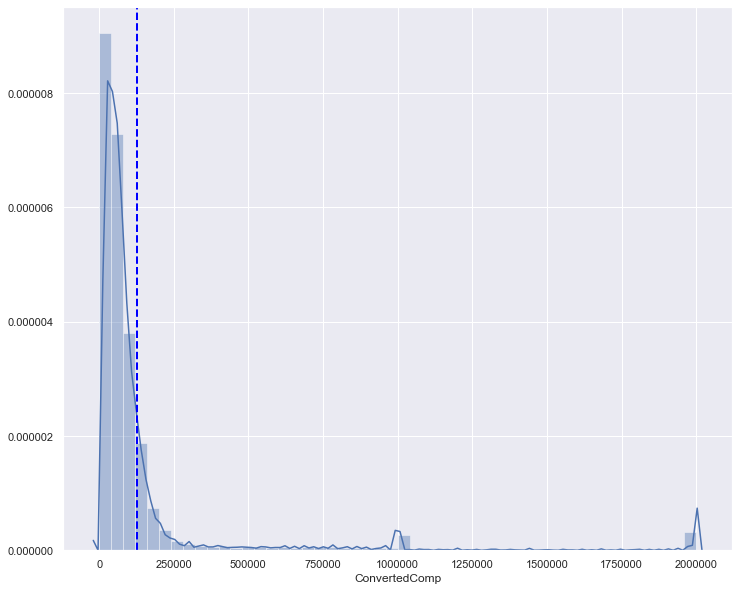

In [5]:
sns.set(rc={'figure.figsize':(12,10)})

sns.distplot(raw_df['ConvertedComp'].dropna())
plt.axvline(raw_df['ConvertedComp'].mean(),color='blue', linestyle='--', lw=2)

- When we limit our scope to below 250,000

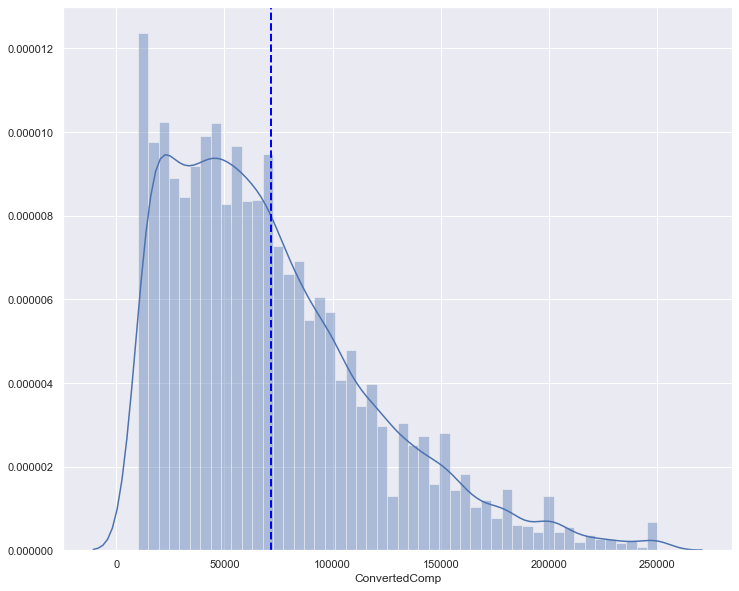

In [6]:
sns.distplot(df['ConvertedComp'])
plt.axvline(df['ConvertedComp'].mean(),color='blue', linestyle='--', lw=2)

Slope: [[2506.16765027]]
Intercept: [51329.52469984]
Root mean squared error:  1969798948.8463223
R2 score:  0.11930379447290262


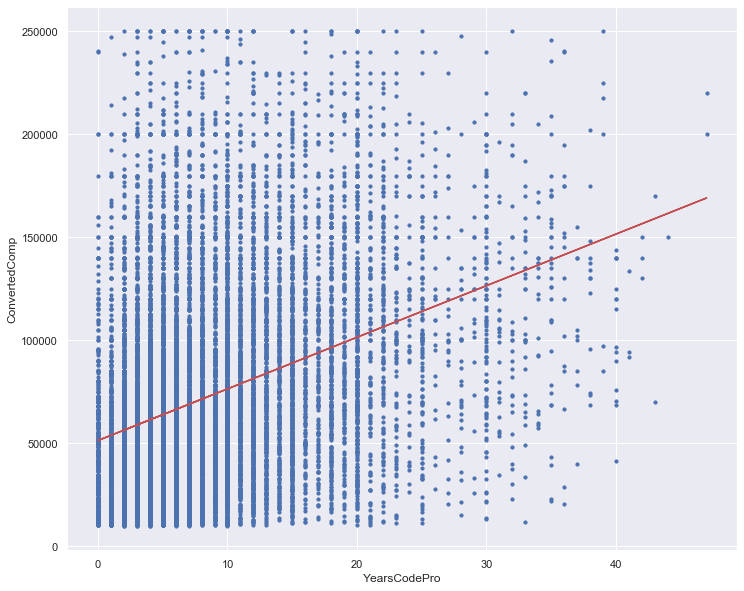

In [7]:
x = df[['YearsCodePro']]
y = df[['ConvertedComp']]

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(x, y)
# Predict
y_predicted = regression_model.predict(x)

# model evaluation
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

# plotting values

# data points
plt.scatter(x, y, s=10)
plt.xlabel(x.columns[0])
plt.ylabel(y.columns[0])

# predicted values
plt.plot(x, y_predicted, color='r')
plt.show()

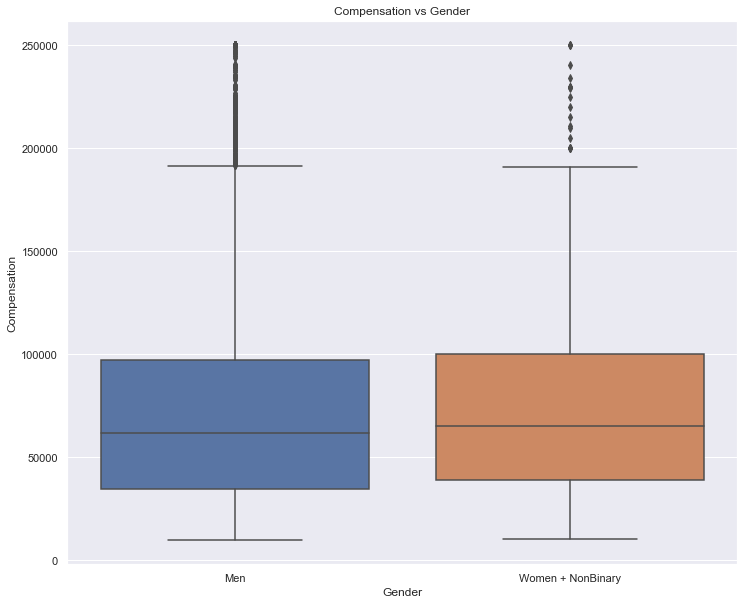

In [8]:
ax = sns.boxplot(x = 'Gender_Man', y = 'ConvertedComp', data = df, order=[1,0])
ax.set_title('Compensation vs Gender')
ax.set_xlabel('Gender')
ax.set_xticklabels(['Men','Women + NonBinary'])
ax.set_ylabel('Compensation')
plt.show()

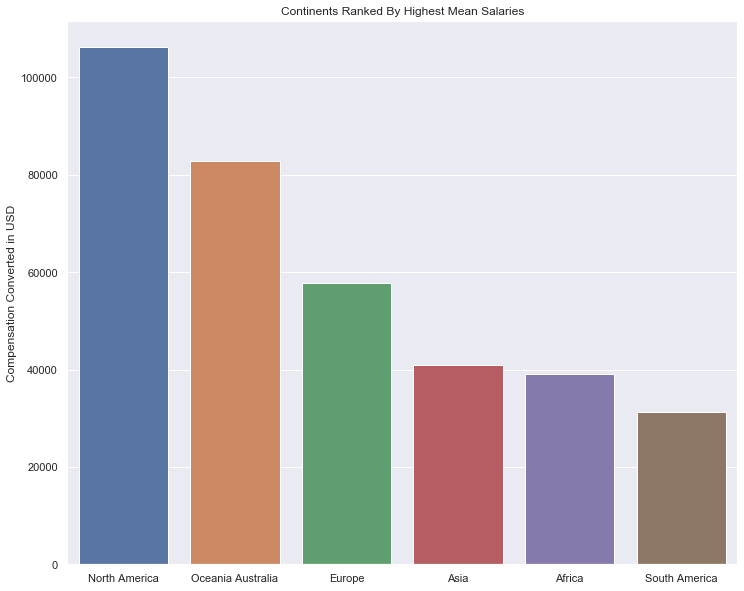

In [9]:
continents = [x for x in df.columns.tolist() if 'Continent' in x]

dfs = []
for continent in continents:
    temp = df.groupby(continent).mean().iloc[[1]]
    temp.index = [continent]
    dfs.append(temp)
df_continents = pd.concat(dfs,sort=False)

df_continents_converted_comp = pd.DataFrame(df_continents['ConvertedComp']).sort_values(by=['ConvertedComp'], ascending=False)

list_continents = [x for x in df_continents_converted_comp.index.tolist()]
list_removed_continents_prefix = [x.replace("Continent_","") for x in list_continents]

list_continents = list_removed_continents_prefix
list_converted_comp = [x for x in df_continents_converted_comp['ConvertedComp']]

sns.barplot(list_continents, list_converted_comp)
# plt.xticks(list_continents)
plt.ylabel('Compensation Converted in USD')
plt.title('Continents Ranked By Highest Mean Salaries')

plt.show()

Text(0.5, 1.0, "Distribution of Participant's Age")

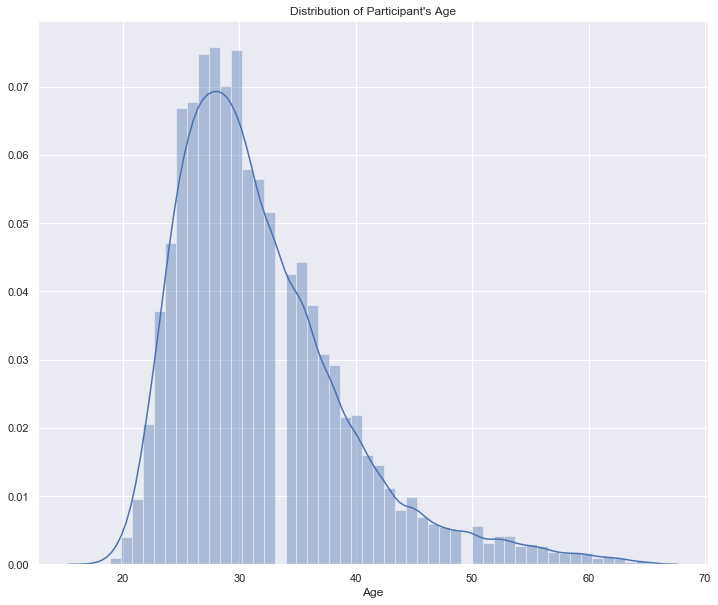

In [10]:
sns.distplot(df['Age'], kde=True)
plt.title("Distribution of Participant's Age")

Text(0.5, 0, ' Years of Experience')

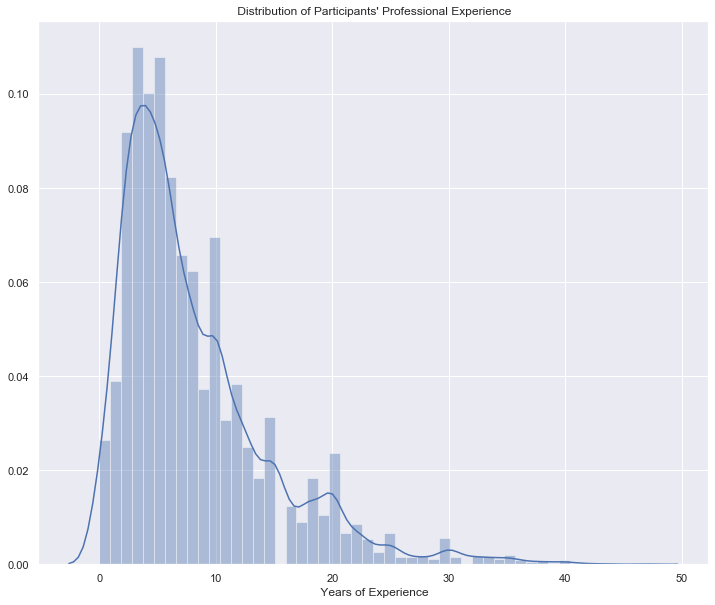

In [11]:
sns.distplot(df['YearsCodePro'], kde=True)
plt.title(" Distribution of Participants' Professional Experience")
plt.xlabel(" Years of Experience")

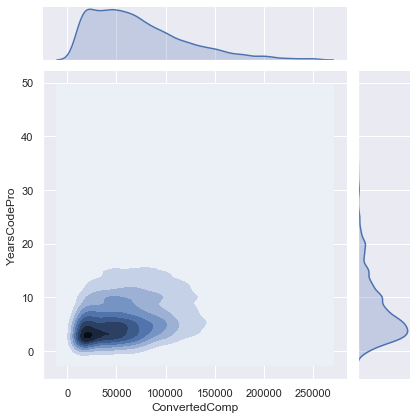

In [12]:
sns.jointplot(x="ConvertedComp", y="YearsCodePro", data=df, kind="kde")

In [ ]:
# sns.pairplot(df);

In [ ]:
# corr = df.corr()
# fig, ax = plt.subplots(figsize=(10,10))

# ax = sns.heatmap(
#     corr,
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

### Dropping 'Respondent'

In [ ]:
df = df.drop(['Respondent'], axis=1)